In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyc-property-sales/nyc-rolling-sales.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import linregress,stats
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from prophet import Prophet
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_absolute_error
pd.options.display.float_format = "{:.2f}".format

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df=pd.read_csv('/kaggle/input/nyc-property-sales/nyc-rolling-sales.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
df2=df.copy()
df2.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [4]:
# BOROUGH sütunundaki değerleri metinlerle değiştirelim
# İlçelere karşılık gelen metinleri belirleyelim
borough_mapping = {
    1: 'Manhattan',
    2: 'Brooklyn',
    3: 'Queens',
    4: 'Bronx',
    5: 'Staten Island'
}

# map() fonksiyonu ile değerleri değiştirelim
df2['BOROUGH'] = df2['BOROUGH'].map(borough_mapping)

In [5]:
df2.info() #df2 dataframindeki değişkenler hk. bilgi edinelim

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  object
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

In [6]:
# İşlem yapılacak değişken isimlerini bir liste olarak tanımlayalım
degiskenler = ["LAND SQUARE FEET", "GROSS SQUARE FEET", "SALE PRICE",'TAX CLASS AT TIME OF SALE']

# Verileri sayısal formata dönüştürelim
for degisken in degiskenler:
    df2[degisken] = pd.to_numeric(df2[degisken], errors="coerce")

kategorikler = ['ZIP CODE', 'TAX CLASS AT TIME OF SALE']
for kategorik in kategorikler: 
    df2[kategorik] = df2[kategorik].astype(object)

# "SALE DATE" sütununu datetime türüne çevirelim
df2["SALE DATE"] = pd.to_datetime(df2["SALE DATE"])

# "SALE YEAR" adında yeni bir sütun oluşturalım ve "SALE DATE" sütunundan yıl bilgisini alalım
df2["SALE YEAR"] = df2["SALE DATE"].dt.year

# "SALE MONTH" adında yeni bir sütun oluşturalım ve "SALE DATE" sütunundan ay bilgisini alalım
df2["SALE MONTH"] = df2["SALE DATE"].dt.month

# "BUILDING AGE" adında yeni bir sütun oluşturalım ve SALE YEAR - YEAR BUILT'e göre binanın yaşını hesaplayalım
df2['BUILDING AGE']=df2['SALE YEAR']-df2['YEAR BUILT']

In [7]:
# BUILDING AGE değişkeninin benzersiz değerlerini alalım ve büyükten küçüğe sıralayalım
unique_values_sorted = np.sort(df2['BUILDING AGE'].unique())[::-1]

# Sonucu gösterelim
print(unique_values_sorted)

[2017 2016  906  337  217  216  191  188  185  182  177  173  172  171
  170  169  168  167  166  165  164  163  161  153  152  147  146  145
  142  141  137  136  135  134  129  128  127  126  125  124  123  122
  121  120  119  118  117  116  115  114  113  112  111  110  109  108
  107  106  105  104  103  102  101  100   99   98   97   96   95   94
   93   92   91   90   89   88   87   86   85   84   83   82   81   80
   79   78   77   76   75   74   73   72   71   70   69   68   67   66
   65   64   63   62   61   60   59   58   57   56   55   54   53   52
   51   50   49   48   47   46   45   44   43   42   41   40   39   38
   37   36   35   34   33   32   31   30   29   28   27   26   25   24
   23   22   21   20   19   18   17   16   15   14   13   12   11   10
    9    8    7    6    5    4    3    2    1    0   -1]


In [8]:
#SALE PRICE değeri 0 veya 0'dan küçük bir değer alamaz
df2 = df2[df2['SALE PRICE'] > 0]

# 'MONTH' sütunundaki değerleri 1 ile 12 aralığında sınırlandırarak diğer değerlere sahip satırları silelim
df2 = df2[(df2['SALE MONTH'] >= 1) & (df2['SALE MONTH'] <= 12)]

#SALE YEAR değeri 0 veya 0'dan küçük bir değer alamaz
df2 = df2[df2['SALE YEAR'] > 0]

# 'RESIDENTIAL UNITS' ve 'COMMERCIAL UNITS' toplamı 'TOTAL UNITS' ile eşit olmayan satırları filtreleyelim onun dışındaki satırları silelim
df2 = df2[df2['RESIDENTIAL UNITS'] + df2['COMMERCIAL UNITS'] == df2['TOTAL UNITS']]
df2 = df2[(df2['TOTAL UNITS'] >0)]

# BUILDING AGE değişkeninde 2017, 2016 ve 0'dan küçük değerleri içeren satırları seçelim
invalid_values = df2[(df2['BUILDING AGE'] <= 0) | (df2['BUILDING AGE'] == 2017) | (df2['BUILDING AGE'] == 2016)]

# Seçilen satırları DataFrame'den çıkaralım
df2 = df2.drop(invalid_values.index)

# 'GROSS SQUARE FEET' ve 'LAND SQUARE FEET' kolonlarını 0'dan büyük olacak şekilde filtreleyelim, onun dışındaki satırları silelim
df2 = df2[(df2['GROSS SQUARE FEET'] > 0) & (df2['LAND SQUARE FEET'] > 0)]


In [9]:
# Gereksiz sütunları kaldıralım
df2.drop(columns=["Unnamed: 0","EASE-MENT","APARTMENT NUMBER", "YEAR BUILT",'LOT',
                  "SALE DATE",'ADDRESS','BUILDING CLASS AT PRESENT','ZIP CODE','BLOCK'], inplace=True)
df2.reset_index(drop=True,inplace=True) #bazı satırlar silindiği için yeniden indeksleme yapıldı 

In [10]:
df2.shape #satırxsütun bilgisi

(29197, 15)

In [11]:
df2.isnull().sum() #eksik değerleri

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
TOTAL UNITS                       0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE YEAR                         0
SALE MONTH                        0
BUILDING AGE                      0
dtype: int64

In [12]:
round(df2.describe([0.05,0.25,0.50,0.75,0.85,0.95,0.99,0.995,0.999]),3) #istatistiksel özet

,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,SALE PRICE,SALE YEAR,SALE MONTH,BUILDING AGE
count,29197.00,29197.00,29197.00,29197.00,29197.00,29197.00,29197.00,29197.00,29197.00
mean,3.05,0.33,3.38,4219.21,4608.82,1636833.75,2016.65,6.59,76.10
std,20.05,14.05,24.62,35587.69,34177.06,17029961.35,0.48,3.47,30.38
min,0.00,0.00,1.00,200.00,120.00,1.00,2016.00,1.00,1.00
5%,1.00,0.00,1.00,1462.00,986.00,110000.00,2016.00,1.00,12.00
25%,1.00,0.00,1.00,2000.00,1360.00,420000.00,2016.00,4.00,57.00
50%,2.00,0.00,2.00,2500.00,1872.00,620000.00,2017.00,6.00,86.00
75%,2.00,0.00,2.00,4000.00,2670.00,950000.00,2017.00,10.00,97.00
85%,3.00,0.00,3.00,4520.00,3300.00,1318600.00,2017.00,11.00,106.00
95%,5.00,1.00,6.00,7490.00,7000.00,3500000.00,2017.00,12.00,116.00


In [13]:
#GROSS SQUARE FEET'in std sapması, ortmasına çok uzak. Yaklaştırmak için:
df2["GROSS SQUARE FEET"].mean() + 2*df2["GROSS SQUARE FEET"].std()

72962.93434913646

In [14]:
df2 = df2[df2["GROSS SQUARE FEET"] < 71500] #GROSS SQUARE FEET'İ 71500'den büyük olan satırlar silinir

In [15]:
df2["LAND SQUARE FEET"].mean() + 2*df2["LAND SQUARE FEET"].std()

29772.153494448212

In [16]:
df2 = df2[df2["LAND SQUARE FEET"] < 30000] #LAND SQUARE FEET'in 30000'den büyük olan satırları silinir
# Veri çerçevesinin indekslerini sıfırlamak
df2.reset_index(drop=True, inplace=True)

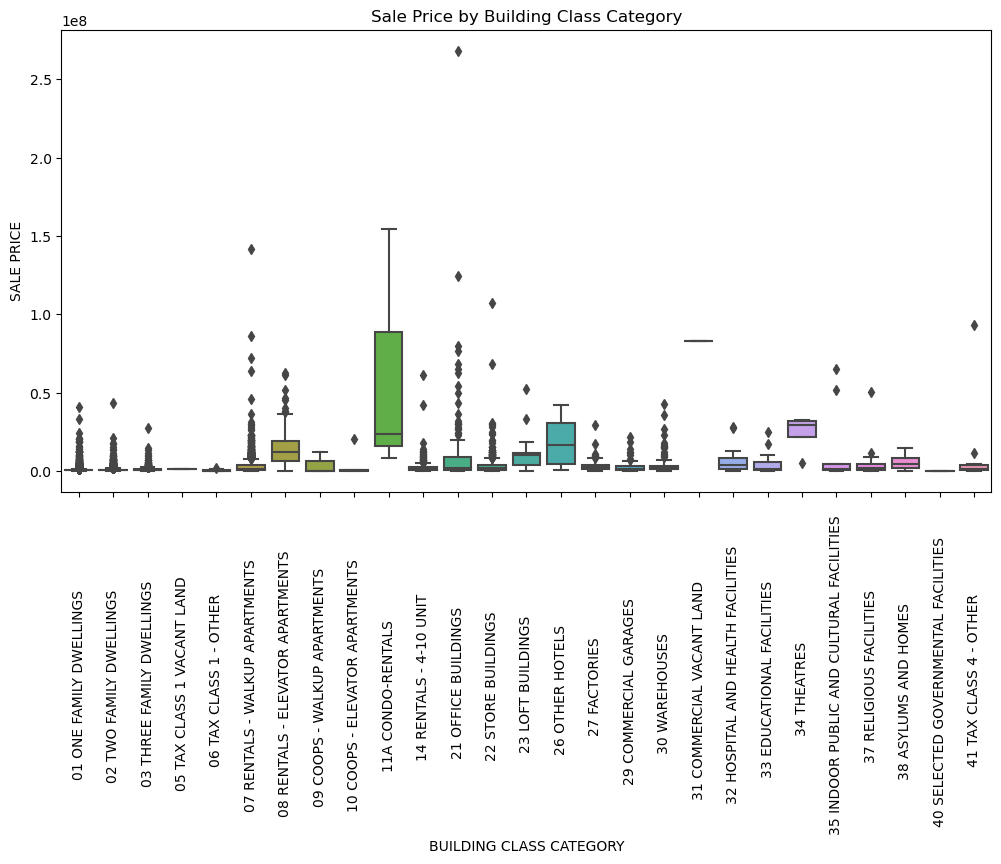

In [17]:
#SALE PRICE'ın Aykırı Değerleri Box Plot Graf
plt.figure(figsize=(12,6))
order = sorted(df2['BUILDING CLASS CATEGORY'].unique())
sns.boxplot(x='BUILDING CLASS CATEGORY', y='SALE PRICE', data=df2, order=order)
plt.xticks(rotation=90)
plt.title('Sale Price by Building Class Category')
plt.show()

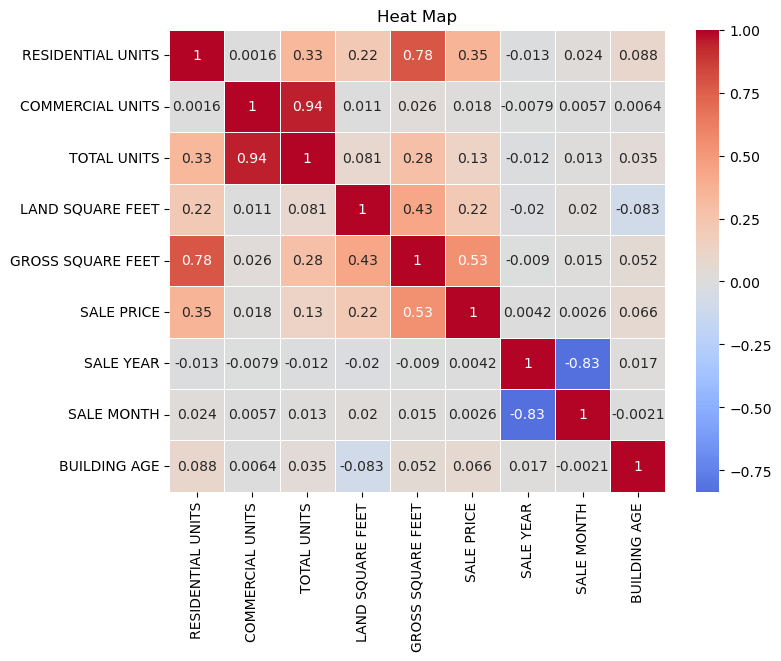

In [18]:
# Isı haritası için ilgili sütunları seçin (örneğin, "RESIDENTIAL UNITS", "COMMERCIAL UNITS" ve "TOTAL UNITS" gibi)
heat_map_data = df2[["RESIDENTIAL UNITS", "COMMERCIAL UNITS", "TOTAL UNITS",'LAND SQUARE FEET',
                    'GROSS SQUARE FEET','SALE PRICE','SALE YEAR','SALE MONTH','BUILDING AGE']]

# Korelasyon matrisini hesaplayalım
correlation_matrix = heat_map_data.corr()

# Isı haritasını çizelim
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Heat Map")
plt.show()

In [19]:
df2['BUILDING CLASS CATEGORY'].value_counts() #her değişkenin toplam adeti

01 ONE FAMILY DWELLINGS                         12892
02 TWO FAMILY DWELLINGS                         10075
03 THREE FAMILY DWELLINGS                        2400
07 RENTALS - WALKUP APARTMENTS                   1790
22 STORE BUILDINGS                                470
14 RENTALS - 4-10 UNIT                            335
21 OFFICE BUILDINGS                               191
29 COMMERCIAL GARAGES                             156
08 RENTALS - ELEVATOR APARTMENTS                  153
30 WAREHOUSES                                     143
27 FACTORIES                                       89
37 RELIGIOUS FACILITIES                            49
32 HOSPITAL AND HEALTH FACILITIES                  22
33 EDUCATIONAL FACILITIES                          21
23 LOFT BUILDINGS                                  18
35 INDOOR PUBLIC AND CULTURAL FACILITIES           15
26 OTHER HOTELS                                    13
41 TAX CLASS 4 - OTHER                             10
06 TAX CLASS 1 - OTHER      

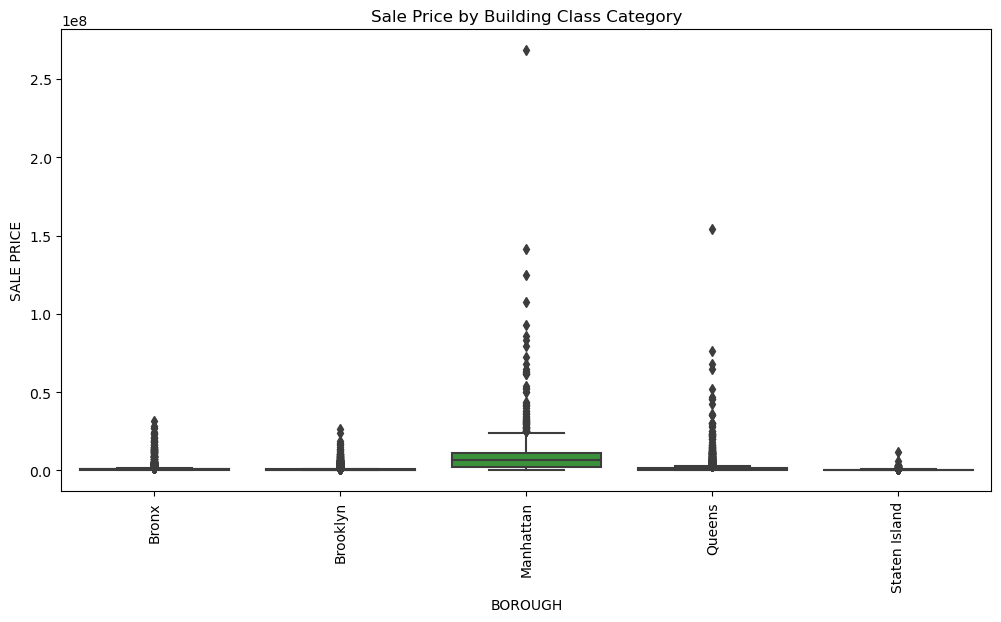

In [20]:
plt.figure(figsize=(12,6))
order = sorted(df2['BOROUGH'].unique())
sns.boxplot(x='BOROUGH', y='SALE PRICE', data=df2, order=order)
plt.xticks(rotation=90)
plt.title('Sale Price by Building Class Category')
plt.show()

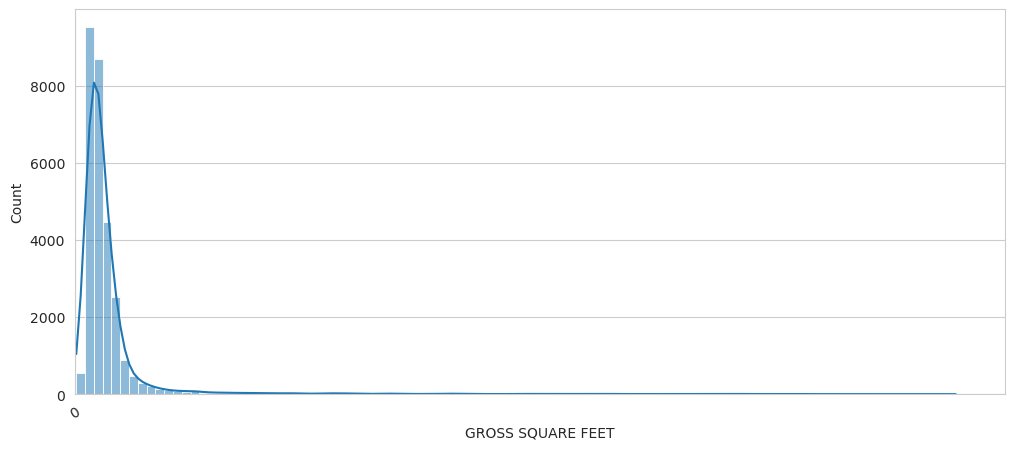

In [21]:
#GROSS SQUARE FEET'in yoğunluk grafiği
from matplotlib import ticker
sns.set_style("whitegrid")
plt.figure(figsize=(12,5))
plotd = sns.histplot(df2[(df2['GROSS SQUARE FEET']>100) & (df2['GROSS SQUARE FEET'] <80000)]['GROSS SQUARE FEET'], kde=True, bins=100)

tick_spacing=250000
plotd.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plotd.set_xlim([0,75000])
plt.xticks(rotation=30)

plt.show()  #sağa çarpık dağılım

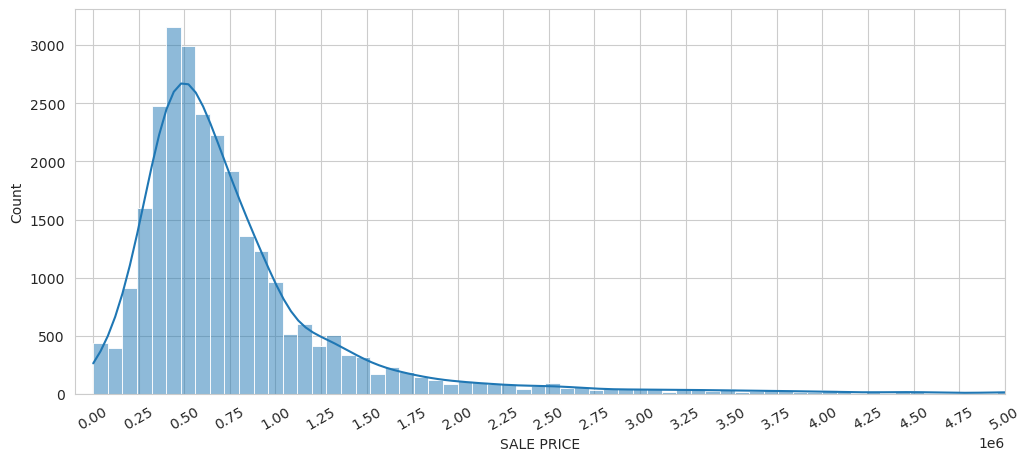

In [22]:
#SALE PRICE'ın yoğunluk grafiği
from matplotlib import ticker
sns.set_style("whitegrid")
plt.figure(figsize=(12,5))
plotd = sns.histplot(df2[(df2['SALE PRICE']>1000) & (df2['SALE PRICE'] <8000000)]['SALE PRICE'], kde=True, bins=100)

tick_spacing=250000
plotd.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plotd.set_xlim([-100000,5000000])
plt.xticks(rotation=30)

plt.show()

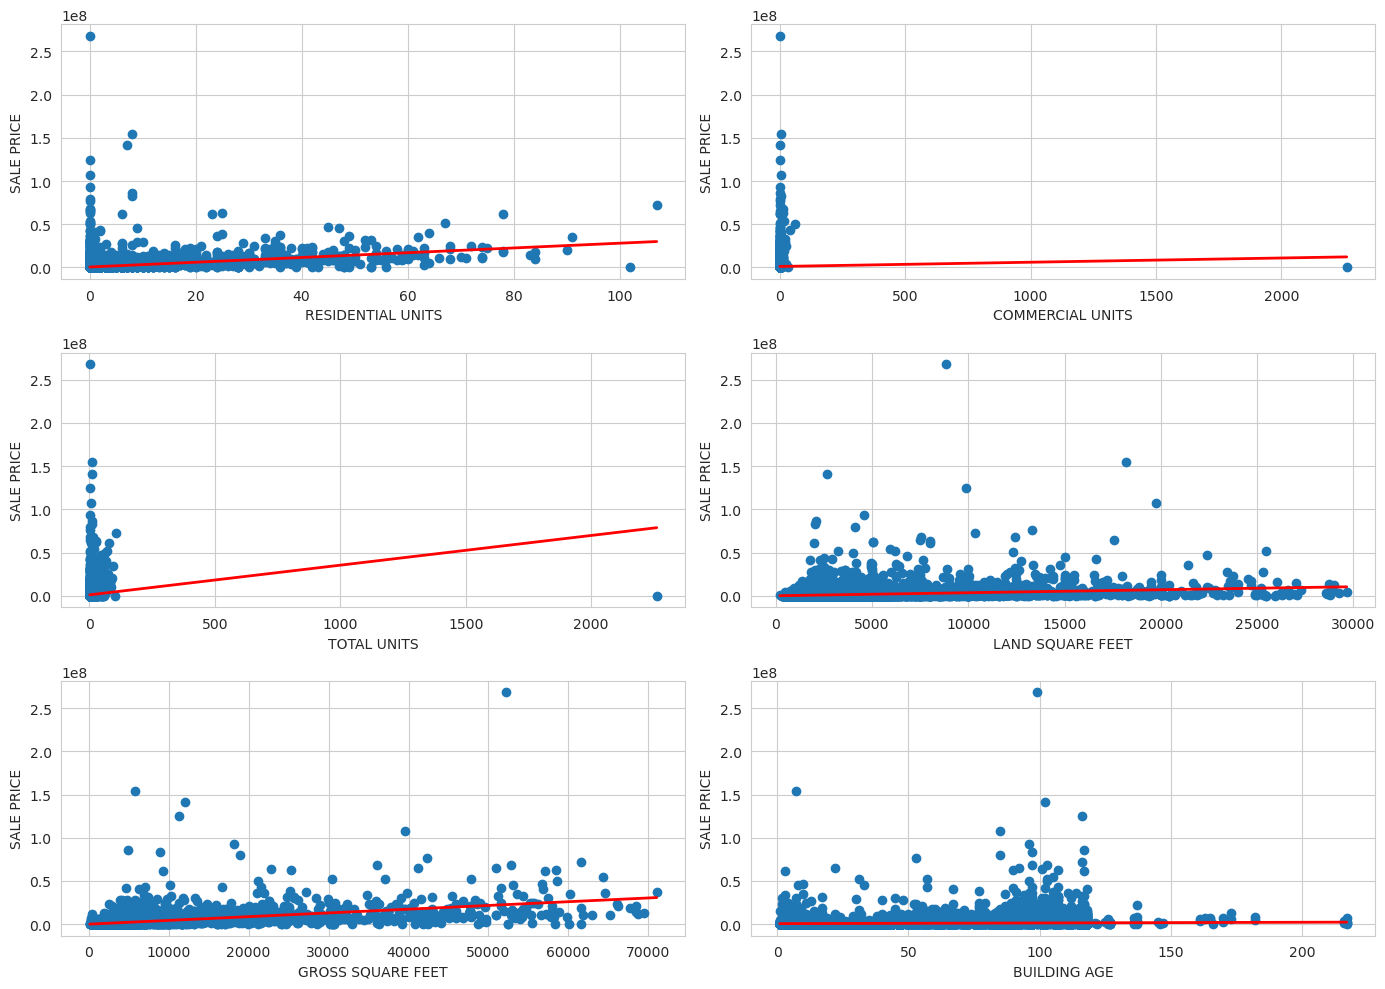

In [23]:
#SALE PRICE'IN DİĞER INT DEĞİŞKENLERİ İLE OLAN SAÇILIM GRAFİKLERİ

# Kolonlar ve ilgili x değişkenleri
kolonlar = ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'BUILDING AGE']

# Grafik boyutunu ayarlayalım
plt.figure(figsize=(14, 10))

# 3x2 scatter plot için alt grafiklerin oluşturulması
for i in range(1, 7):
    plt.subplot(3, 2, i)
    x = df2[kolonlar[i-1]]
    y = df2['SALE PRICE']
    plt.scatter(x, y)
    plt.xlabel(kolonlar[i-1])
    plt.ylabel('SALE PRICE')
    
    # Doğrusal regresyon
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_values = np.array([x.min(), x.max()])
    y_values = intercept + slope * x_values
    
    # Doğruyu çizelim
    plt.plot(x_values, y_values, color='red', linewidth=2)
    
# Grafikleri gösterelim
plt.tight_layout()
plt.show()

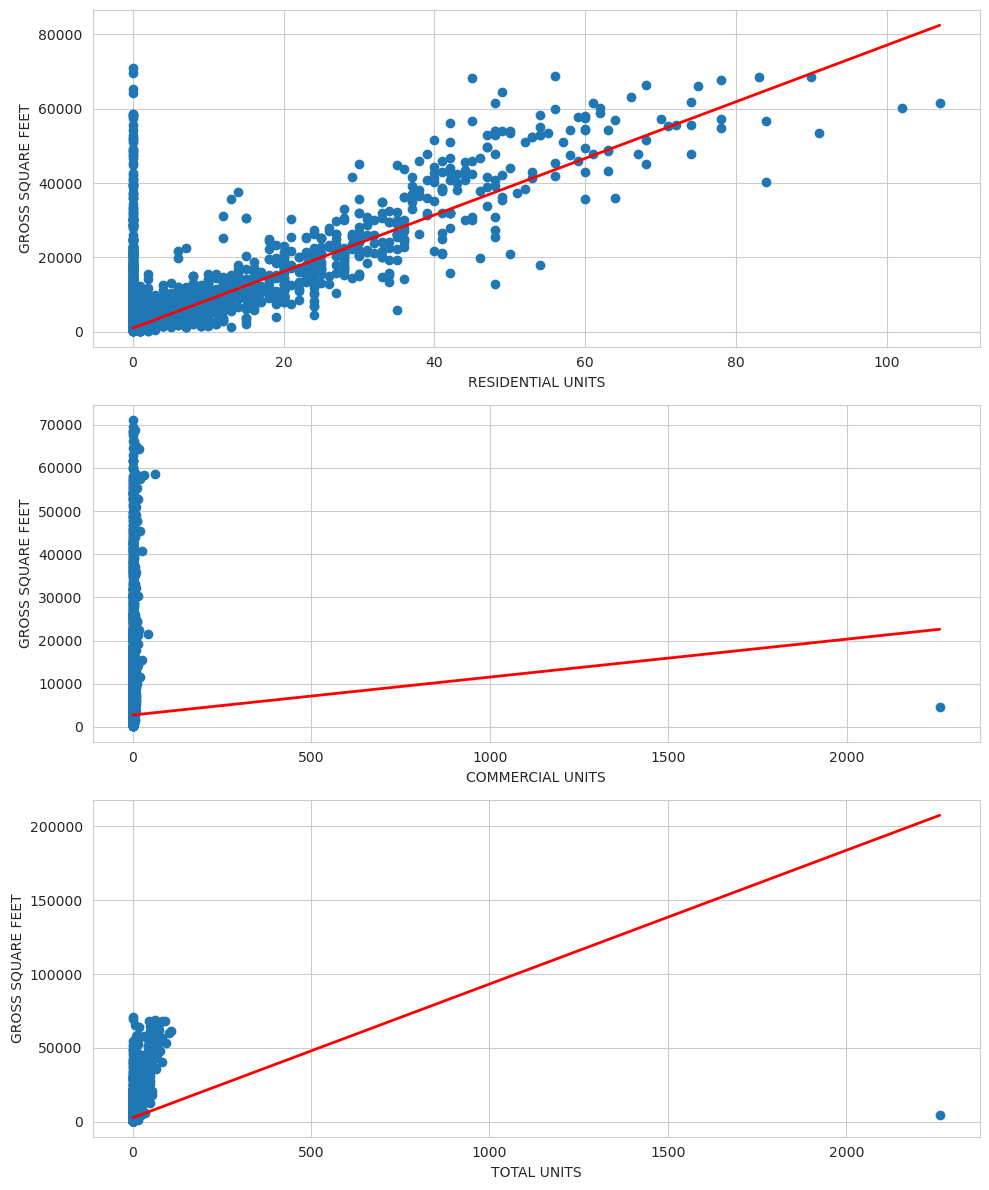

In [24]:
#GROSS SQUARE FEET'İN DİĞER INT DEĞİŞKENLERLE OLAN SAÇILIM GRAFİĞİ

# Kolonlar ve ilgili x değişkenleri
kolonlar = ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS']

# Grafik boyutunu ayarlayalım
plt.figure(figsize=(10,12))

for i in range(1, 4):
    plt.subplot(3, 1, i)
    x = df2[kolonlar[i-1]]
    y = df2['GROSS SQUARE FEET']
    plt.scatter(x, y)
    plt.xlabel(kolonlar[i-1])
    plt.ylabel('GROSS SQUARE FEET')
    
    # Doğrusal regresyon
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_values = np.array([x.min(), x.max()])
    y_values = intercept + slope * x_values
    
    # Doğruyu çizelim
    plt.plot(x_values, y_values, color='red', linewidth=2)
    
# Grafikleri gösterelim
plt.tight_layout()
plt.show()

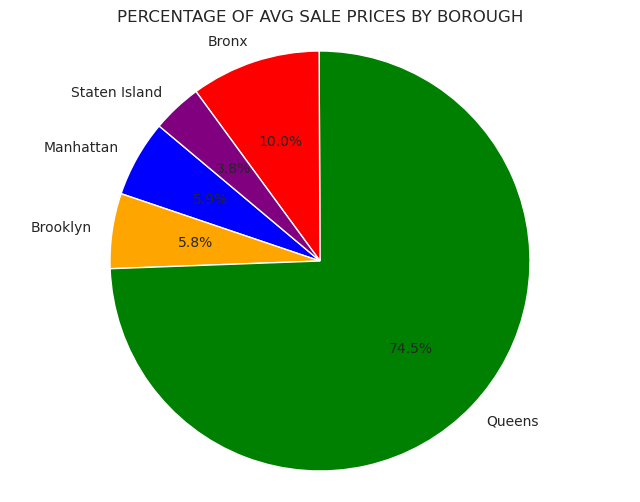

In [25]:
# BOROUGH sütunundaki benzersiz değerleri alalım
borough_benzersiz = df2['BOROUGH'].unique()

# Her BOROUGH değeri için SALE PRICE ortalama değerleri hesaplayalım
ortalama_satis_fiyati = df2.groupby('BOROUGH')['SALE PRICE'].mean()

# Pasta grafiği için renkler
renkler = ['blue', 'orange', 'green', 'red','purple']

# Pasta grafiğini oluşturalım
plt.figure(figsize=(8, 6))
plt.pie(ortalama_satis_fiyati, labels=borough_benzersiz, colors=renkler, autopct='%1.1f%%', startangle=140)
plt.title('PERCENTAGE OF AVG SALE PRICES BY BOROUGH')
plt.axis('equal')  # Daireyi düzgün bir daire olarak yapar
plt.show()

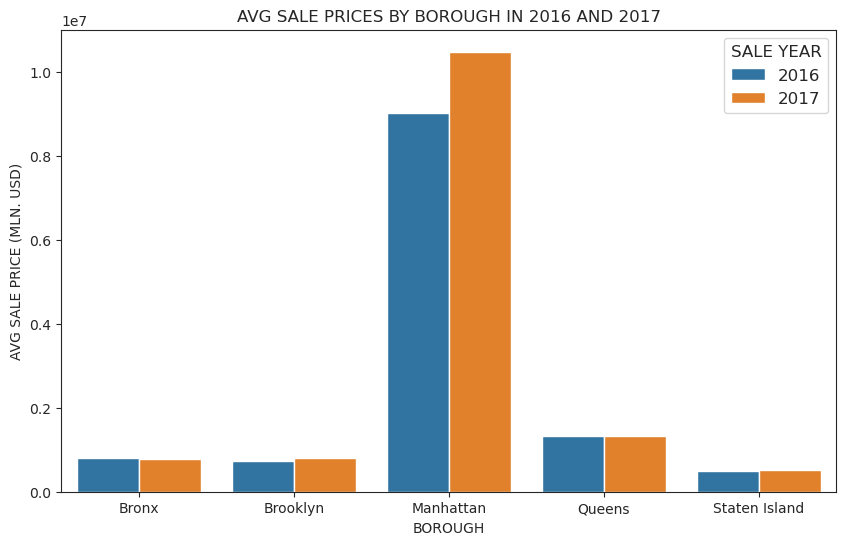

In [26]:
# 2016 ve 2017 yılına ait verileri seçelim
df_year = df2[df2['SALE YEAR'].isin([2016, 2017])]

# BOROUGH'un benzersiz değerlerine göre gruplayıp 2016 ve 2017 yıllarındaki SALE PRICE'ların ortalamasını alalım
mean_prices = df_year.groupby(['BOROUGH', 'SALE YEAR'])['SALE PRICE'].mean().reset_index()

# Çubuk grafiğini çizelim
plt.figure(figsize=(10, 6))
sns.set_style("ticks")  # Arka plandaki grid çizgilerini kaldırır
sns.barplot(x='BOROUGH', y='SALE PRICE', hue='SALE YEAR', data=mean_prices)
plt.xlabel("BOROUGH")
plt.ylabel("AVG SALE PRICE (MLN. USD)")
plt.title("AVG SALE PRICES BY BOROUGH IN 2016 AND 2017")
plt.legend(title='SALE YEAR', title_fontsize='12', fontsize='12', loc='upper right')
plt.show()

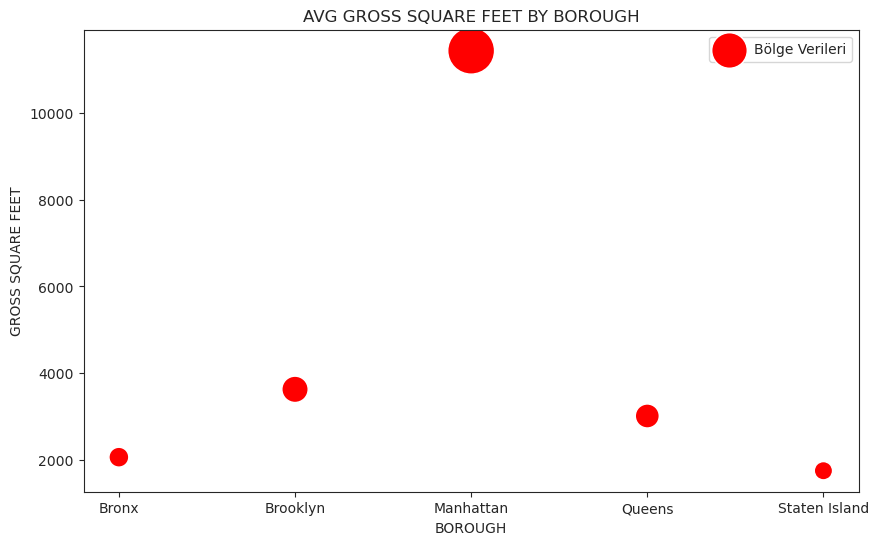

In [27]:
# Her BOROUGH için GROSS SQUARE FEET'in ortalama değerini hesaplayalım
ortalama_gross_sqft = df2.groupby('BOROUGH')['GROSS SQUARE FEET'].mean().reset_index()

# Grafiği oluşturmak için seaborn kullanalım
plt.figure(figsize=(10, 6))

# Baloncuk grafik oluşturalım
sns.scatterplot(x='BOROUGH', y='GROSS SQUARE FEET', data=ortalama_gross_sqft, s=ortalama_gross_sqft['GROSS SQUARE FEET']*0.1, color='red')

plt.xlabel("BOROUGH")
plt.ylabel("GROSS SQUARE FEET")
plt.title("AVG GROSS SQUARE FEET BY BOROUGH")
plt.legend(['Bölge Verileri', 'Ortalama GROSS SQUARE FEET'], loc='upper right')

plt.show()

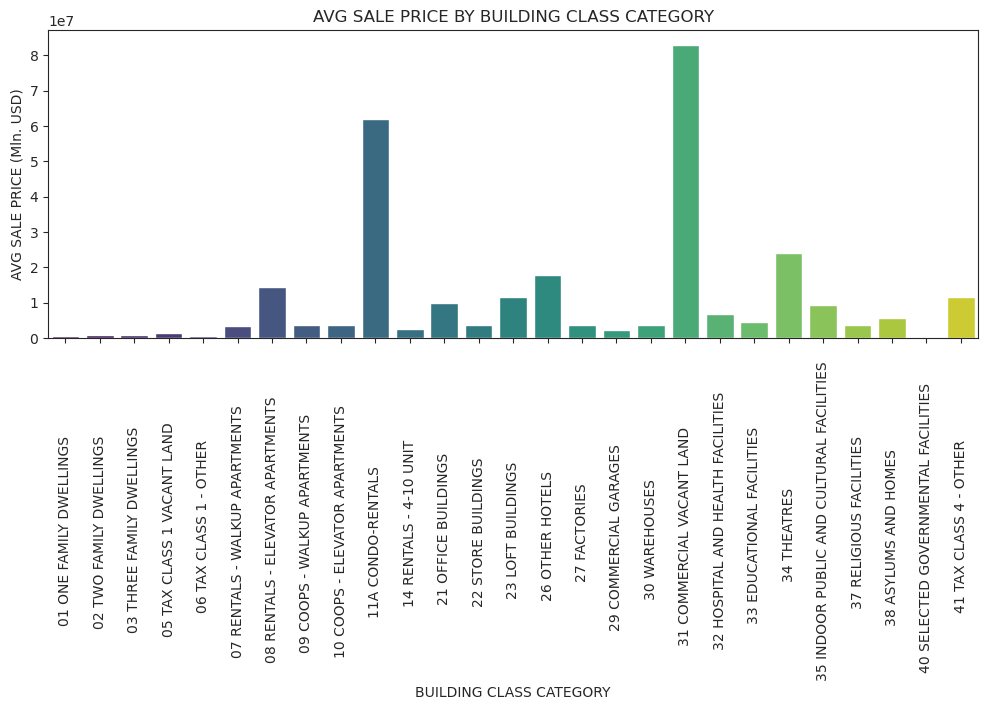

In [28]:
# Her BUILDING CLASS CATEGORY için SALE PRICE'in ortalama değerini hesaplayalım
ortalama_sale_price = df2.groupby('BUILDING CLASS CATEGORY')['SALE PRICE'].mean().reset_index()

# Çubuk grafiği oluşturmak için seaborn kullanalım
plt.figure(figsize=(12, 4))
sns.barplot(x='BUILDING CLASS CATEGORY', y='SALE PRICE', data=ortalama_sale_price, palette='viridis')

# X etiketlerini döndürerek daha iyi görünürlük sağlayalım
plt.xticks(rotation=90)

plt.xlabel("BUILDING CLASS CATEGORY")
plt.ylabel("AVG SALE PRICE (Mln. USD)")
plt.title("AVG SALE PRICE BY BUILDING CLASS CATEGORY")

plt.show()

In [29]:
#Lineer Regresyon Modeli Kuralım

# Bağımsız değişkenler (X) ve bağımlı değişken (y) olarak ayıralım
X = df2.drop(['SALE PRICE','BUILDING CLASS AT TIME OF SALE',
              'TAX CLASS AT PRESENT','BUILDING AGE','SALE YEAR','SALE MONTH','NEIGHBORHOOD',
             'LAND SQUARE FEET','COMMERCIAL UNITS','RESIDENTIAL UNITS','TOTAL UNITS'], axis=1)
y = df2['SALE PRICE']

# Kategorik değişkenlere one-hot dönüşümü yapalım
X_encoded = pd.get_dummies(X, columns=['BOROUGH','BUILDING CLASS CATEGORY','TAX CLASS AT TIME OF SALE'], drop_first=True)

# Veri kümesini eğitim ve test kümelerine bölelim
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Doğrusal regresyon modelini oluştur ve eğitelim
model = LinearRegression()
model.fit(X_train, y_train)

# Eğitilen modelin test verileri üzerinde tahmin yapması
y_pred = model.predict(X_test)

# R-kare skoru ve modelin doğrusal regresyon denklemi
r_squared = model.score(X_test, y_test)
print("R-kare skoru:", r_squared)

print("Modelin denklemi:")
print("y =", model.intercept_, end=" ")
for i, feature in enumerate(X_encoded.columns):
    print("+", model.coef_[i], "*", feature, end=" ")


R-kare skoru: 0.2397985654426752
Modelin denklemi:
y = 127655.84834716772 + 344.16293093786 * GROSS SQUARE FEET + -491270.1881610451 * BOROUGH_Brooklyn + 5828920.548167547 * BOROUGH_Manhattan + 284188.9353465683 * BOROUGH_Queens + -202094.34542445306 * BOROUGH_Staten Island + -141205.98939889704 * BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS                     + -269706.3079734301 * BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS                   + 21250.130398933496 * BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND                  + -26104.82167003651 * BUILDING CLASS CATEGORY_06 TAX CLASS 1 - OTHER                      + -8386568.503000392 * BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS              + -8551612.301490929 * BUILDING CLASS CATEGORY_08 RENTALS - ELEVATOR APARTMENTS            + -15900051.764691459 * BUILDING CLASS CATEGORY_09 COOPS - WALKUP APARTMENTS                + -22227928.277443554 * BUILDING CLASS CATEGORY_10 COOPS - ELEVATOR APARTMENTS        

/tmp/ipykernel_20/445231774.py:10: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_encoded = pd.get_dummies(X, columns=['BOROUGH','BUILDING CLASS CATEGORY','TAX CLASS AT TIME OF SALE'], drop_first=True)


In [30]:
#Random Forrest modeli kuralım

# Veri kümesini eğitim ve test kümelerine bölelim
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Random Forest regresyon modelini oluşturalım ve eğitelim
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Eğitilen modelin test verileri üzerinde tahmin yapması
y_pred_rf = rf_model.predict(X_test)

# R-kare skoru
r_squared_rf = r2_score(y_test, y_pred_rf)
print("Random Forest R-kare skoru:", r_squared_rf)

Random Forest R-kare skoru: 0.3838733609906074


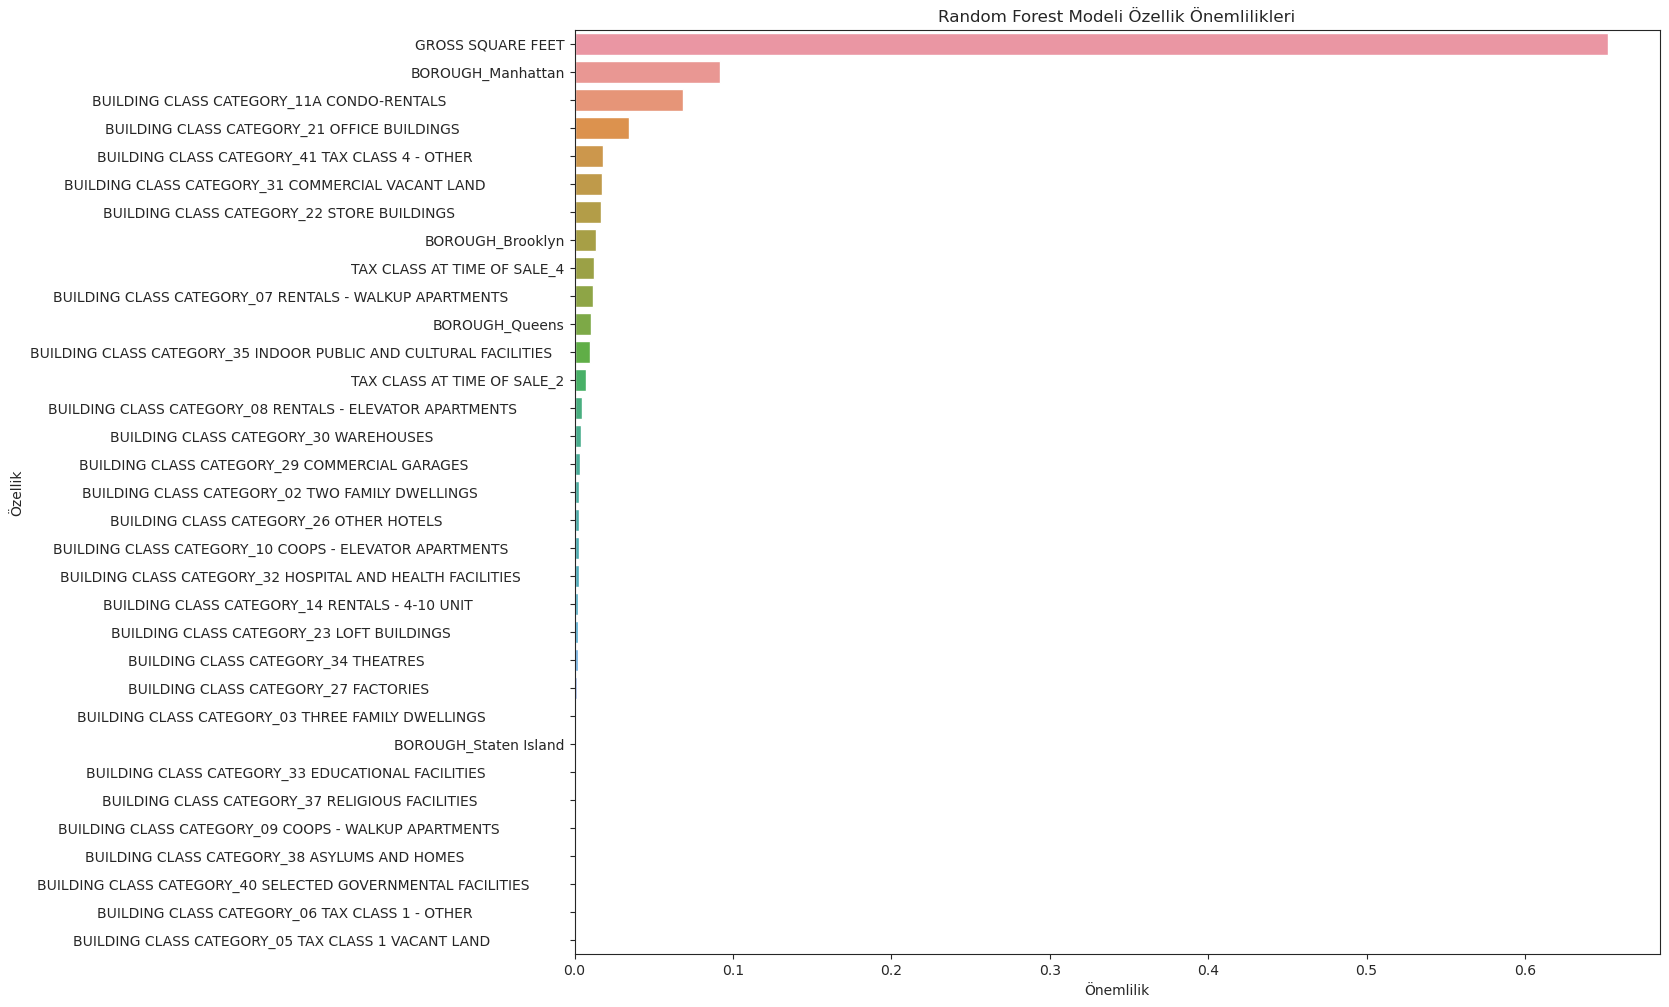

In [31]:
# Özellik önemliliklerini alalım
feature_importances = rf_model.feature_importances_

# Özellik önemliliklerini veri çerçevesine dönüştürelim
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})

# Özellik önemliliklerine göre sıralayalım
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Özellik önemliliklerini çubuk grafik olarak gösterelim
plt.figure(figsize=(14, 12))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel("Önemlilik")
plt.ylabel("Özellik")
plt.title("Random Forest Modeli Özellik Önemlilikleri")
plt.show()

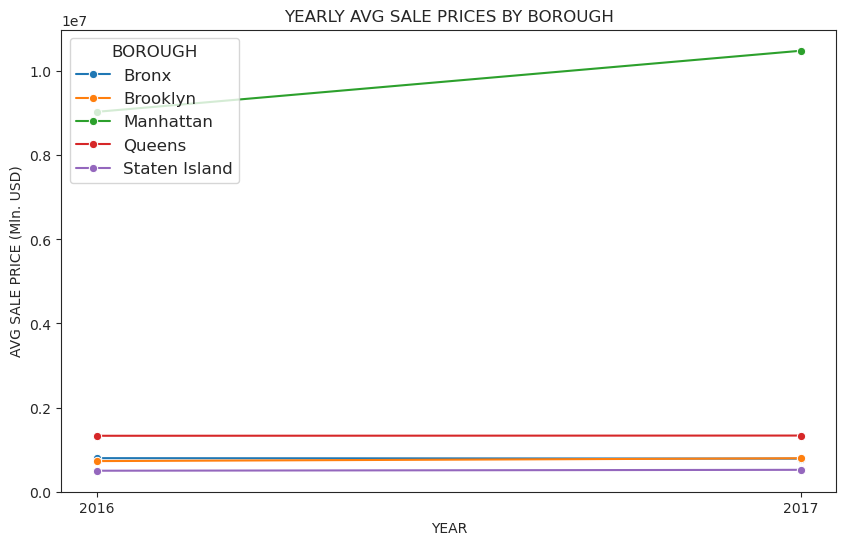

In [32]:
# 2016 ve 2017 yıllarına ait verileri seçelim
df_yil = df2[df2['SALE YEAR'].isin([2016, 2017])]

# BOROUGH'un benzersiz değerlerine göre gruplayıp yıllık ortalama SALE PRICE'ları alalım
ortalama_fiyatlar = df_yil.groupby(['BOROUGH', 'SALE YEAR'])['SALE PRICE'].mean().reset_index()

# Çizgi grafiği
plt.figure(figsize=(10, 6))
sns.set_style("ticks")  # Arka plandaki grid çizgilerini kaldırır

# Her BOROUGH'un benzersiz değeri için çizgi ve nokta ile görselleştirelim
for borough in ortalama_fiyatlar['BOROUGH'].unique():
    data = ortalama_fiyatlar[ortalama_fiyatlar['BOROUGH'] == borough]
    sns.lineplot(x='SALE YEAR', y='SALE PRICE', data=data, marker='o', label=borough)

plt.xticks([2016, 2017], ['2016', '2017'])  # Sadece 2016 ve 2017 değerlerini gösterir
plt.xlabel("YEAR")
plt.ylabel("AVG SALE PRICE (Mln. USD)")
plt.title("YEARLY AVG SALE PRICES BY BOROUGH")
plt.legend(title='BOROUGH', title_fontsize='12', fontsize='12', loc='upper left')
plt.show()

In [33]:
# "SALE DATE" adında yeni bir sütun oluşturma
df2['SALE DATE'] = pd.to_datetime(df2['SALE YEAR'].astype(str) + '-' + df2['SALE MONTH'].astype(str))

In [34]:
# "SALE DATE" sütunundaki tarihleri datetime formatına dönüştürme
df2['SALE DATE'] = pd.to_datetime(df2['SALE DATE'])

# "SALE PRICE" sütununu "y" olarak adlandırma
df2.rename(columns={'SALE PRICE': 'y'}, inplace=True)

# BOROUGH'lara göre ayrı tahminler yapmak için bir sözlük oluşturalım
forecast_by_borough = {}

# Her BOROUGH için tahminleri yapalım
for borough in df2['BOROUGH'].unique():
    df_borough = df2[df2['BOROUGH'] == borough]
    df_prophet = df_borough.rename(columns={'SALE DATE': 'ds', 'SALE PRICE': 'yhat'})
    
    model = Prophet()
    model.fit(df_prophet)
    
    future_dates = model.make_future_dataframe(periods=12, freq='M', include_history=False)
    forecast = model.predict(future_dates)
    
    forecast_by_borough[borough] = forecast

# Tahminleri ekrana yazdırma
for borough, forecast in forecast_by_borough.items():
    print(f"---- {borough} ----")
    print(forecast[['ds', 'yhat']].head(12))

22:15:53 - cmdstanpy - INFO - Chain [1] start processing
22:15:53 - cmdstanpy - INFO - Chain [1] done processing
22:15:54 - cmdstanpy - INFO - Chain [1] start processing
22:15:54 - cmdstanpy - INFO - Chain [1] done processing
22:15:55 - cmdstanpy - INFO - Chain [1] start processing
22:15:55 - cmdstanpy - INFO - Chain [1] done processing
22:15:56 - cmdstanpy - INFO - Chain [1] start processing
22:15:56 - cmdstanpy - INFO - Chain [1] done processing
22:15:57 - cmdstanpy - INFO - Chain [1] start processing
22:15:57 - cmdstanpy - INFO - Chain [1] done processing


---- Manhattan ----
           ds        yhat
0  2017-08-31 11216117.46
1  2017-09-30 11400913.40
2  2017-10-31 11591869.20
3  2017-11-30 11776665.13
4  2017-12-31 11967620.94
5  2018-01-31 12158576.74
6  2018-02-28 12331052.94
7  2018-03-31 12522008.74
8  2018-04-30 12706804.68
9  2018-05-31 12897760.48
10 2018-06-30 13082556.41
11 2018-07-31 13273512.22
---- Brooklyn ----
           ds       yhat
0  2017-08-31  881630.56
1  2017-09-30  902158.60
2  2017-10-31  923370.92
3  2017-11-30  943898.97
4  2017-12-31  965111.28
5  2018-01-31  986323.60
6  2018-02-28 1005483.11
7  2018-03-31 1026695.42
8  2018-04-30 1047223.47
9  2018-05-31 1068435.79
10 2018-06-30 1088963.83
11 2018-07-31 1110176.15
---- Queens ----
           ds       yhat
0  2017-08-31 1279576.37
1  2017-09-30 1226605.44
2  2017-10-31 1171868.80
3  2017-11-30 1118897.87
4  2017-12-31 1064161.23
5  2018-01-31 1009424.60
6  2018-02-28  959985.06
7  2018-03-31  905248.43
8  2018-04-30  852277.49
9  2018-05-31  797540.86
10 201